In [46]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import urllib.request
%matplotlib inline

In [47]:
paths = ['https://raw.githubusercontent.com/SergKostarev/time-series-markov-processes/refs/heads/main/tom_1.txt',
         'https://raw.githubusercontent.com/SergKostarev/time-series-markov-processes/refs/heads/main/tom_2.txt',
         'https://raw.githubusercontent.com/SergKostarev/time-series-markov-processes/refs/heads/main/tom_3.txt',
         'https://raw.githubusercontent.com/SergKostarev/time-series-markov-processes/refs/heads/main/tom_4.txt']

In [48]:
text = '';
try:
  for path in paths:
    with urllib.request.urlopen(path) as response:
      text_content_bytes = response.read()
      text_content = text_content_bytes.decode('utf-8').lower()
      text_content = re.sub('[^a-zA-Z\u0400-\u04FF\u0401\u0451 ]','', text_content)
      text = text + text_content
except urllib.error.URLError as e:
    print(f"An error occurred: {e.reason}")

In [49]:
chars = list(sorted(set(text)))
chars_dict = {l: i for i, l in enumerate(chars)}

Матрица переходных вероятностей:

In [50]:
probabilities = np.zeros((len(chars_dict), len(chars_dict)))
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[chars_dict[cp], chars_dict[cn]] += 1
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])
df = pd.DataFrame(probabilities, index=(c for c in chars), columns=(c for c in chars))

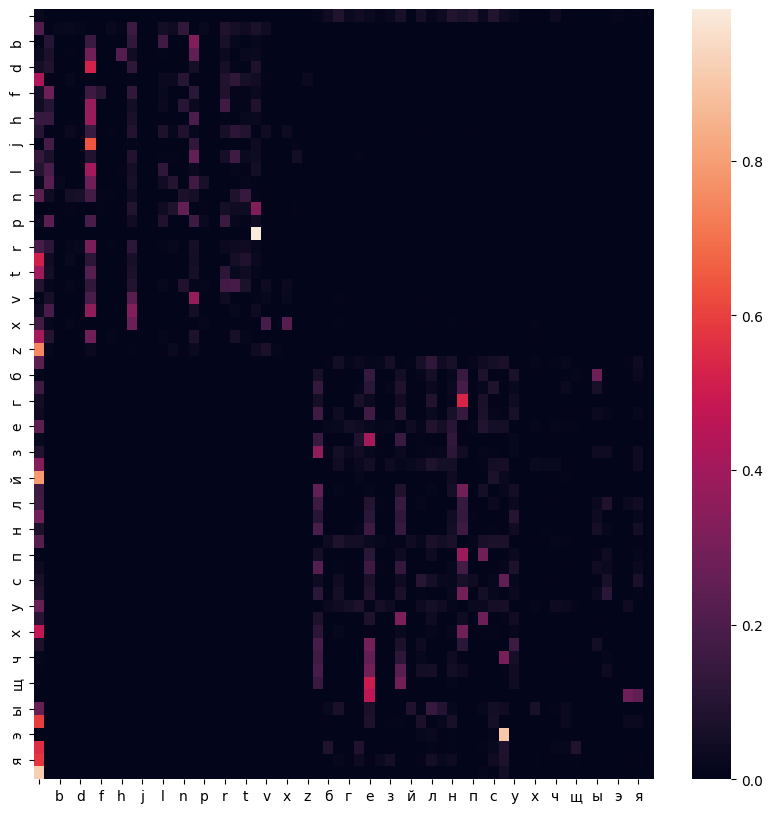

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(df)
plt.show()

Вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р»:

In [52]:
p_3 = probabilities @ probabilities @ probabilities
1 / len(chars) * p_3[chars_dict['п'], chars_dict['р']]

np.float64(0.0005374651361745269)

Сгенерировать слово, начинающееся с буквы «Б» длиной восемь символов:

In [53]:
np.random.seed(6)
s = []
start = 'б'
s.append(start)
length = 7
for i in range(length):
    index = chars_dict[s[i]]
    next_char = np.random.choice(chars, p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бывс бсп


Оценка ряда через HMM:

In [54]:
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

In [55]:
series = pd.read_csv("https://raw.githubusercontent.com/SergKostarev/time-series/refs/heads/main/weekly-closings-of-the-dowjones-.csv")["Close"]

In [56]:
values = series.values.reshape(-1, 1)

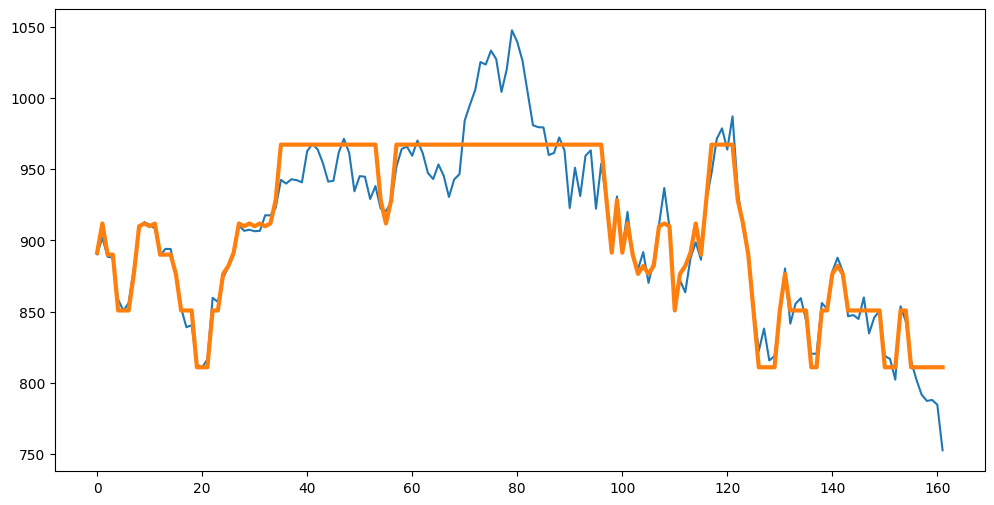

In [57]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]

plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

Прогноз ряда на 10 шагов вперед с использованием средних каждой из 10 компонент:

In [58]:
last_state = labels[-1]
forecast = []
for i in range (10):
  next_state_probs = model.transmat_[last_state, :]
  next_state = np.argmax(next_state_probs)
  forecast.append(model.means_[next_state])
  last_state = next_state

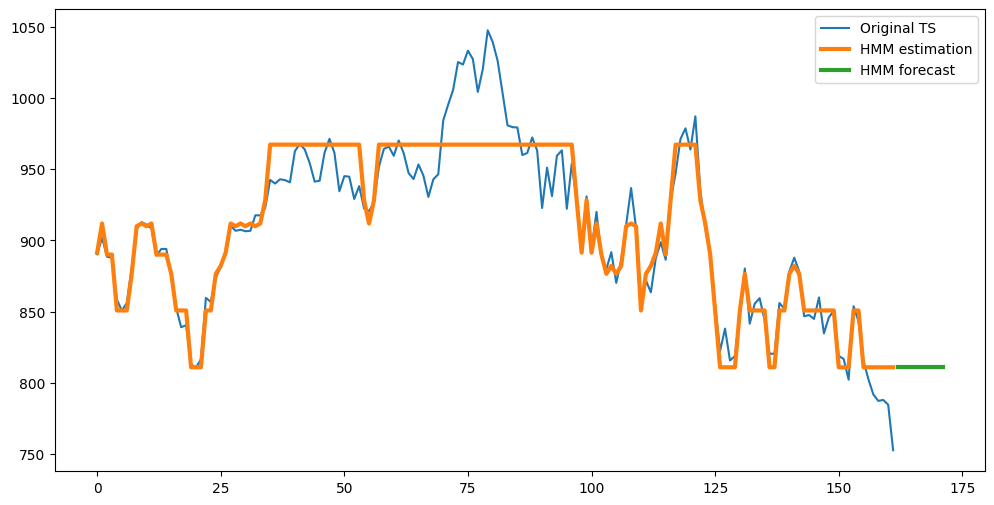

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(values, label='Original TS')
plt.plot(means, linewidth=3, label='HMM estimation')
plt.plot(pd.Series(forecast, index=range(len(values), len(values) + len(forecast))), linewidth=3, label='HMM forecast')
plt.legend()
plt.show()